In [4]:
import warnings
from importlib import reload
from functools import partial, lru_cache

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm, trange
from joblib import delayed
from modAL import batch
from art.metrics import empirical_robustness
from art.attacks.evasion import *
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from tabulate import tabulate
from art.estimators.classification.scikitlearn import ScikitlearnSVC
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
import scipy

from ipynb.fs.defs import Bias
from ipynb.fs.defs.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D, plot_dataset_2D

import libactive
import libadversarial
import libdatasets
from libactive import MyActiveLearner, active_split
from libadversarial import adversarial, uncertainty, random_batch
from libutil import ProgressParallel
from libdatasets import *
import librun
from librun import run

Using sklearn


In [13]:
def unbalanced(X_train, X_test, y_train, y_test, amount=1e-1, rand=None, config_str=None, i=None):
    unique = np.unique(y_train)
    
    idx4 = y_train==unique[0]
    y4 = y_train[idx4]
    X4 = X_train[idx4]
    idx9 = y_train==unique[1]
    y9 = y_train[idx9]
    X9 = X_train[idx9]
    idx = rand.choice(len(y4), int(y4.shape[0]*amount), replace=False)
    X4 = X4[idx]
    y4 = y4[idx]
    return np.concatenate((X4, X9), axis=0), X_test, np.concatenate((y4, y9), axis=0), y_test

In [6]:
reload(libdatasets); from libdatasets import *

In [7]:
def wrap(func, *args, **kwargs):
    wrapper = lambda: lru_cache()(func)(*args, **kwargs)
    for attr in [attr for attr in dir(func) if not attr.startswith('__')]:
        setattr(wrapper, attr, getattr(func, attr))
    return wrapper

In [16]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        ("mnist", lambda: lru_cache()(mnist)(digits=(4,9))),
        ("quickdraw", lambda: lru_cache()(quickdraw)(1000, classes=("cat", "dolphin"))),
        ("bbbp", lambda: lru_cache()(bbbp)()),
        ("sonar", lambda: lru_cache()(sonar)()),
        ("german", lambda: lru_cache()(german)()),
        #("newsgroups_faith", wrap(newsgroups, 1000, ('alt.atheism', 'soc.religion.christian'))),
    ],
    "dataset_mutators": {
        #"none": (lambda *x, **kwargs: x),
        "unbalanced": unbalanced,
    },
    "methods": [
        ("random", partial(random_batch, n_instances=10)),
        ("uncertainty", partial(batch.uncertainty_batch_sampling, n_instances=10)),
        ("deepfool", partial(adversarial, Attack=partial(DeepFool, verbose=False), n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 0.01,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True
    }
}

In [18]:
results = librun.run(matrix)

In [21]:
plots = [result[0] for result in results]
classifiers = [result[1] for result in results]

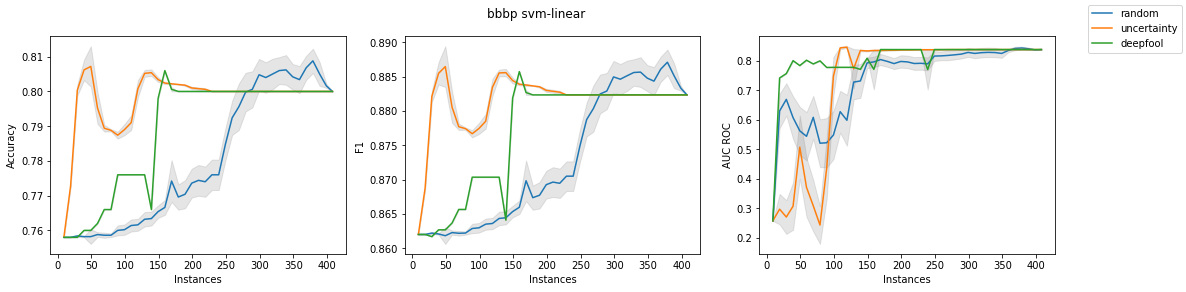

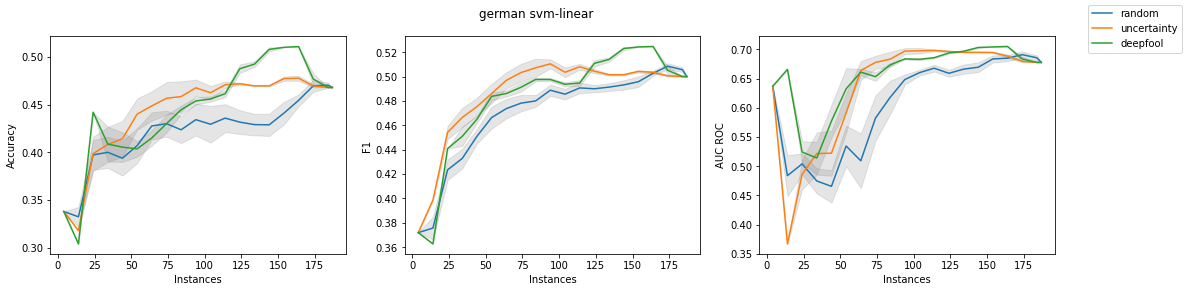

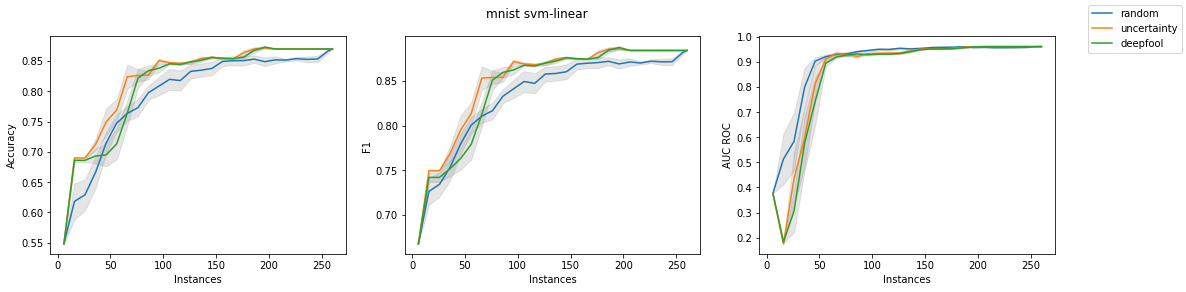

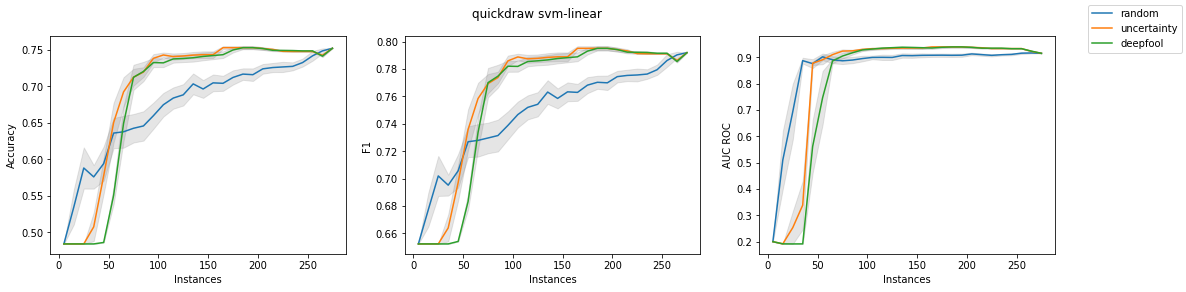

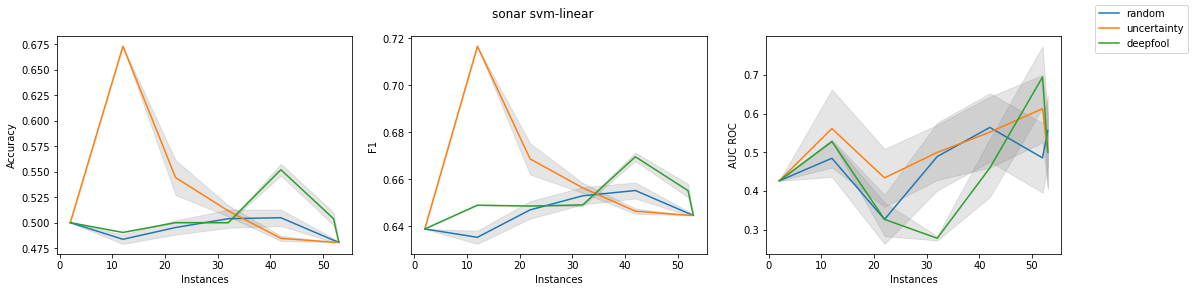

In [20]:
librun.plot(plots)